![Image of Yaktocat](https://oepfelbaum.com/wp_live/wp-content/themes/appletree/dist/img/logo-main_ed18093c87353e6715bcc40c699c37f9.png)

# Oe LuKB Market Risk - Jupyter Notebook

**Author**: Fabian Arter <br>
**Date**: `2022-01-29` - `2022-05-10`

The aim of this notebook is the explain the main concepts of market risk.

## Volatility & Return Distribution

### Set Input Data


<div class="alert alert-block alert-info">
<b>Input:</b> Please choose here for which titles you would like to see historical data. 
</div>



   Check **Yahoo Finance** for all tickers: [https://finance.yahoo.com](https://finance.yahoo.com/lookup) 

Enter in the below `data.frame` the desired tickers (incl. a friendly name, which can be chosen by you)

In [168]:
#input.tickers.df = data.frame(ticker=c("LUKN.SW","BTC-USD","ROG.SW"),
#                              friendly.name=c("LUKN.SW","Bitcoin (USD)","Roche"))


input.tickers.df = data.frame(ticker=c("ROG.SW", 
                                       "NESN.SW", 
                                       "NOVN.SW", 
                                       "^SSMI")
                                    ,
                               friendly.name=c("Roche", 
                                               "Nestle", 
                                               "Novartis", 
                                               "SMI"
                                               )
                              )


<div class="alert alert-block alert-info">
<b>Input:</b> Please choose here the start and end date of the historical price data. Also specify length of rolling periods - make sure data history is large enough!
</div>



In [171]:
start.date = as.Date("2018-01-01")
last.date  = Sys.Date() # today 
n.days.rolling=c(60,120,250,500) # specify length of rolling periods - make sure data history is large enough

In [172]:
print(input.tickers.df)
message(paste("start date:",start.date))
message(paste("last date: ",last.date))
message("Rolling Periods in Days: ")
cat(n.days.rolling)

   ticker friendly.name
1  ROG.SW         Roche
2 NESN.SW        Nestle
3 NOVN.SW      Novartis
4   ^SSMI           SMI


start date: 2018-01-01
last date:  2022-05-11
Rolling Periods in Days: 


60 120 250 500

### Installing and loading R packages

In [173]:
install.packages("ggplot2")
install.packages("BatchGetSymbols")
install.packages("dplyr")
install.packages("reshape2")


#install.packages("devtools")


#install.packages("reshape2")
library(ggplot2)
library(BatchGetSymbols)
library(dplyr)
library(reshape2)
#library(devtools)
#devtools::install_github('msperlin/yfR')
# library(yfR)




Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


### Loading Historical End of Day Data from Yahoo Finance

In [174]:


#' etlFinData
#'
#' @param start.date Start Date of the historical price data
#' @param end.date  End Date of the historical price data
#' @param input.tickers.df Data Frame with the products we wish to have the prices, this includes the ticker symbol and a friendly name
#' @return a list with two data frames: cumulated.returns.data.long and cumulated.returns.data.long
#' @export
etlFinData <- function(start.date=as.Date("2018-01-01"), 
                       last.date =Sys.Date(),
                       input.tickers.df = data.frame(ticker=c("LUKN.SW","AIR.PA"),
                                                     friendly.name=c("LUKN.SW","AIRBUS"))
) {
  
  # load data via BatchGetSymbols
  daily.returns.data.long <- suppressWarnings(BatchGetSymbols::BatchGetSymbols(
    tickers      = as.character(input.tickers.df$ticker),
    first.date   = start.date,
    last.date    = last.date,
    freq.data    = "daily",
    type.return  = "log",
    cache.folder = file.path(tempdir(), 'BGS_Cache') )$df.tickers)
  
  
  # add friendly names
  daily.returns.data.long <-  merge(daily.returns.data.long, input.tickers.df, by="ticker")
  
  daily.returns.data.long[is.na(daily.returns.data.long$ret.adjusted.prices),]$ret.adjusted.prices <- 0
  daily.returns.data.long <- na.omit(daily.returns.data.long)
  
  daily.returns.data.long <- data.frame(ref.date        = daily.returns.data.long$ref.date,
                                        friendly.name   = as.character(daily.returns.data.long$friendly.name),
                                        price.adjusted  = daily.returns.data.long$price.adjusted,
                                        daily.return    = daily.returns.data.long$ret.adjusted.prices)
  
  daily.returns.data.wide <- reshape2::dcast(daily.returns.data.long,  ref.date ~ friendly.name, value.var = "daily.return")
  daily.returns.data.wide <- na.omit(daily.returns.data.wide)
  
  # cumulated returns wide
  cumulated.returns.data.wide  <- if(nrow(input.tickers.df) !=1) {
    as.data.frame(cbind(ref.date = daily.returns.data.wide$ref.date, apply(daily.returns.data.wide[,2:ncol(daily.returns.data.wide)], 2, cumsum)))
    
  }
    

  # cumulated returns long
  cumulated.returns.data.long <- if(nrow(input.tickers.df) !=1) {
    cumulated.returns.data.long               <- reshape2::melt(cumulated.returns.data.wide, id.vars=1, measure.vars = 2:ncol(cumulated.returns.data.wide))
    cumulated.returns.data.long$ref.date      <- as.Date(cumulated.returns.data.long$ref.date, origin = "1970-01-01")
    cumulated.returns.data.long$name          <- as.character(cumulated.returns.data.long$variable) ; cumulated.returns.data.long$variable <- NULL
    cumulated.returns.data.long$cumul.return  <- cumulated.returns.data.long$value ; cumulated.returns.data.long$value <- NULL
    cumulated.returns.data.long
  } else {
    data.frame(ref.date = daily.returns.data.long$ref.date, name = daily.returns.data.long$friendly.name, cumul.return=cumsum(daily.returns.data.long$daily.return))
  }
  
  cumulated.returns.data.wide$ref.date      <- as.Date(as.numeric(cumulated.returns.data.wide$ref.date), origin = "1970-01-01")
  
  return(list(daily.returns.data.long     = daily.returns.data.long,
              daily.returns.data.wide     = daily.returns.data.wide,
              cumulated.returns.data.long = cumulated.returns.data.long,
              cumulated.returns.data.wide = cumulated.returns.data.wide))
  
}    

In [175]:
PF.daily.return <- etlFinData(start.date = start.date,
                               last.date = last.date,
                              input.tickers.df = input.tickers.df)

PF.daily.return.wide <- PF.daily.return$daily.returns.data.wide
PF.daily.return.long <- PF.daily.return$daily.returns.data.long
PF.daily.cumul.long  <- PF.daily.return$cumulated.returns.data.long 




Running BatchGetSymbols for:
   tickers =ROG.SW, NESN.SW, NOVN.SW, ^SSMI
^GSPC | yahoo (1|1) | Found cache file
ROG.SW | yahoo (1|4) | Found cache file - Got 97.3% of valid prices | Looking good!
NESN.SW | yahoo (2|4) | Found cache file - Got 97.3% of valid prices | Well done!
NOVN.SW | yahoo (3|4) | Found cache file - Got 97.3% of valid prices | OK!
^SSMI | yahoo (4|4) | Found cache file - Got 96.5% of valid prices | Got it!

### Historical Returns Normalized

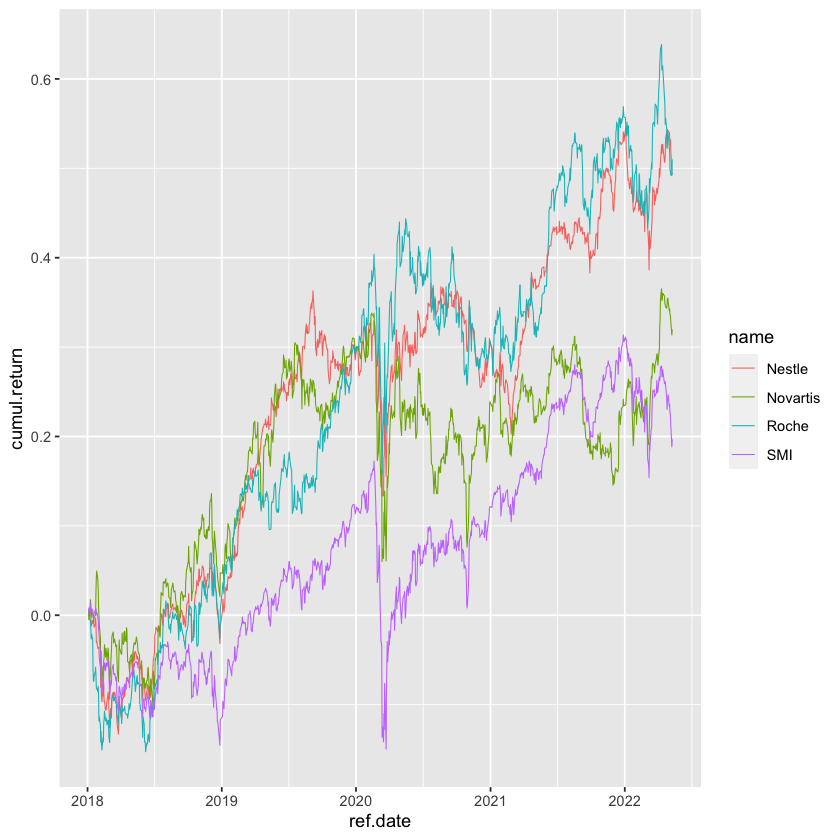

In [176]:
# Cumulated return plot
ggplot(PF.daily.cumul.long, aes(y=cumul.return, x=ref.date, color=name)) + geom_line(size=0.3)  

### Daily Returns

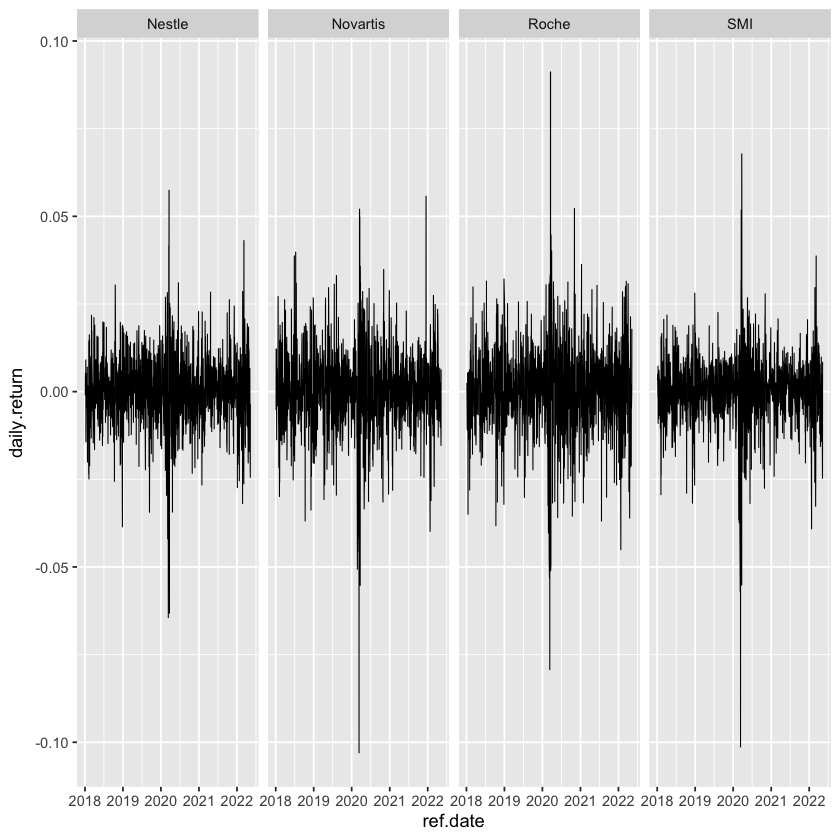

In [177]:
# return plot
ggplot(PF.daily.return.long, aes(y=daily.return, x=ref.date)) + geom_line(size=0.3)  + facet_grid(~ friendly.name)
 

### Histogram of Daily Returns

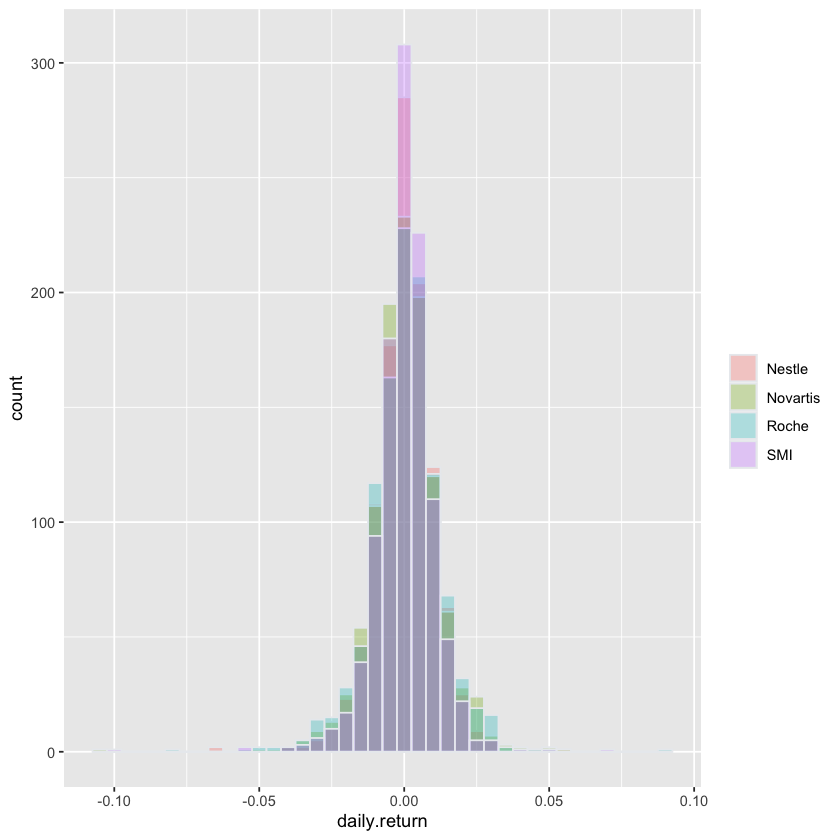

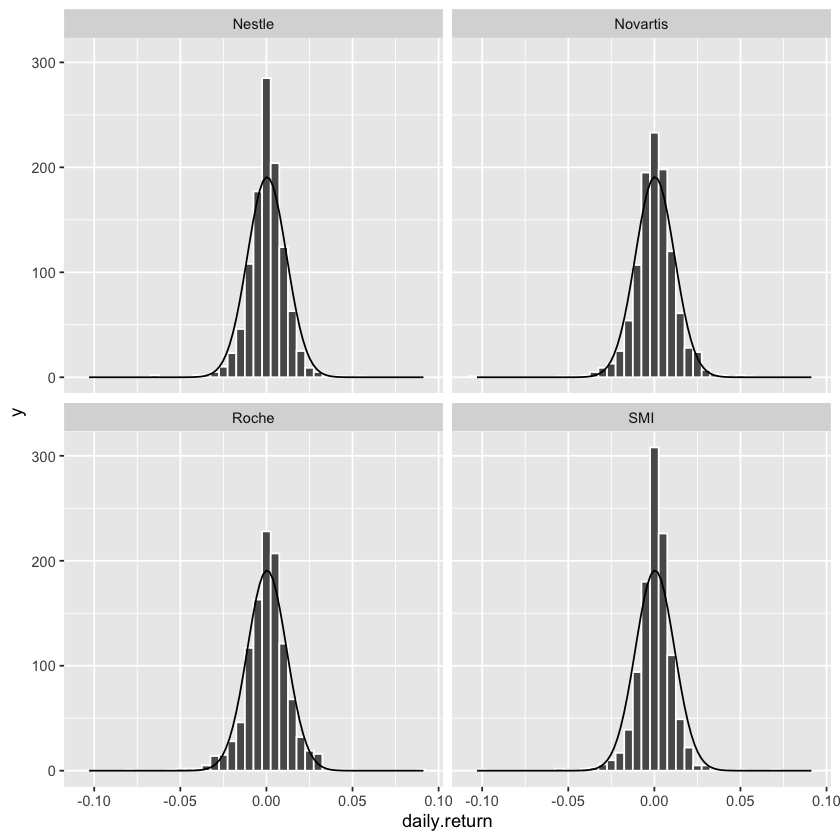

In [178]:
binwidth.set = 0.005
stocks.count = nrow(input.tickers.df)

ggplot(PF.daily.return.long, aes(x=daily.return, fill=friendly.name,binwidth = binwidth.set)) +
    geom_histogram( color="#e9ecef", alpha=0.3, position = 'identity',binwidth = binwidth.set) +
    labs(fill="")

ggplot(PF.daily.return.long, aes(x=daily.return, binwidth = binwidth.set)) +
    geom_histogram( color="#e9ecef", alpha=0.3, position = 'identity',binwidth = binwidth.set) +
    labs(fill="") + facet_wrap(~friendly.name) + 
    geom_histogram(colour = "white", binwidth = binwidth.set) +
stat_function(fun = function(x) dnorm(x, mean = mean(PF.daily.return.long$daily.return), sd = sd(PF.daily.return.long$daily.return)) * nrow(PF.daily.return.long)/stocks.count * binwidth.set) 

### Statistics: Daily Retun Percentiles & Check for Normality
**Shapiro-Wilk Test for Normality** 
Null hypothesis: The data is normally distributed. If p> 0.05, normality can be assumed

In [179]:
 
PF.daily.return.long %>% group_by(friendly.name) %>% 
  summarise(min = min(daily.return)
            ,max = max(daily.return)
            ,mean = mean(daily.return)
            ,sd = sd(daily.return)
            ,n = n()
            ,q05 = quantile(daily.return, .05)
            ,q01 = quantile(daily.return, .01)
            ,q95 = quantile(daily.return, .95)
            ,q99 = quantile(daily.return, .99)
            ,shapiro.normality.pvalue = as.numeric(shapiro.test(daily.return)[2])
            ) 



friendly.name,min,max,mean,sd,n,q05,q01,q95,q99,shapiro.normality.pvalue
Nestle,-0.06444836,0.05742957,0.0004528519,0.01030022,1093,-0.01628593,-0.02748558,0.01616687,0.02485550,4.765713e-17
Novartis,-0.10299928,0.05575005,0.0002936021,0.01205997,1093,-0.01794961,-0.03166647,0.01921142,0.02974024,2.330780e-19
Roche,-0.07929974,0.09119587,0.0004524850,0.01274713,1093,-0.01901426,-0.03554938,0.02000836,0.03104994,5.065987e-18
SMI,-0.10133930,0.06780465,0.0001819759,0.01027321,1082,-0.01579020,-0.02944180,0.01484306,0.02315993,3.722966e-26


### QQ Plots

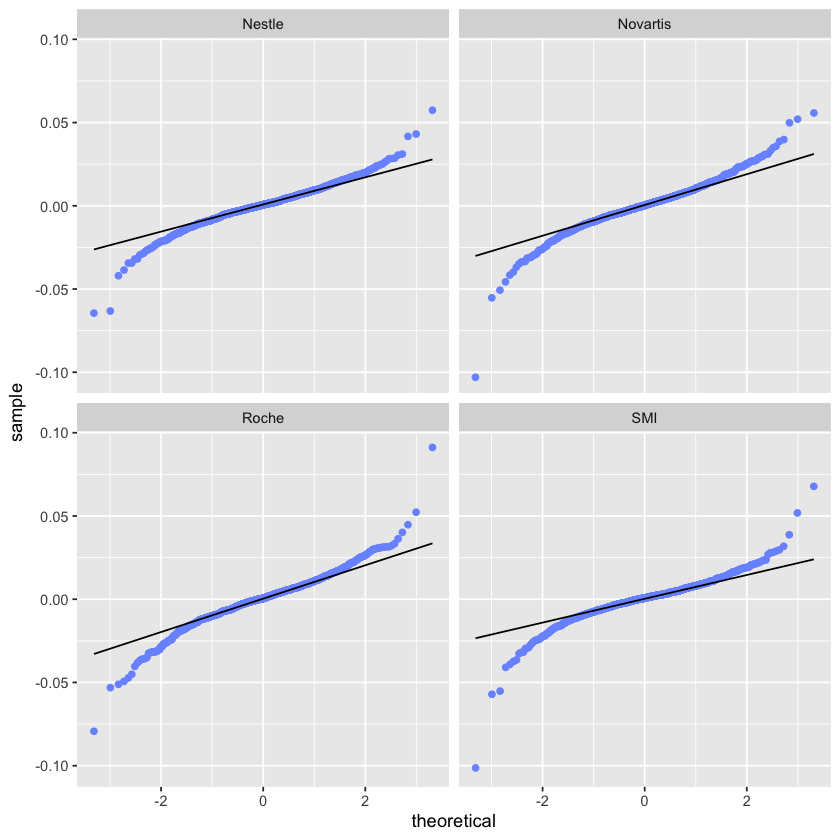

In [180]:
ggplot(PF.daily.return.long) +
    stat_qq(aes(sample=daily.return),colour = "#7997FF") + 
    stat_qq_line(aes(sample = daily.return)) + xlab("theoretical") + ylab("sample") +
   facet_wrap(~friendly.name)  

## Volatility

### Unweighted Historical Volatility

In [181]:

rollingVolaSingleTicker <- function(PF.daily.return.long, n.days.rolling=120) {
  
  n.days.total <- nrow(PF.daily.return.long)
  n.rows       <- n.days.total-n.days.rolling
  
  rolling.vola.data.result <- data.frame(ref.date         = rep(as.Date(NA),n.rows),
                                         start.date       = rep(as.Date(NA),n.rows),       
                                         friendly.name    = rep(NA,n.rows),
                                         estimator        = rep(NA,n.rows),
                                         type             = rep("vola",n.rows),
                                         method           = "simple - rolling",
                                         n.days.rolling   = rep(n.days.rolling, n.rows),
                                         n.observations   = rep(NA, n.rows))
  
                                  
  for (j in 1:n.rows) {
   # print(j)
    rolling.vola.data.result$ref.date[j]        <- PF.daily.return.long$ref.date[(n.days.rolling+j)]
    rolling.vola.data.result$start.date[j]      <- PF.daily.return.long$ref.date[(j)]
    rolling.vola.data.result$friendly.name[j]   <- as.character(PF.daily.return.long$friendly.name[(n.days.rolling+j)])
    rolling.vola.data.result$estimator[j]       <- sd(PF.daily.return.long$daily.return[j:(n.days.rolling+j)])
    rolling.vola.data.result$n.observations[j]  <- length(PF.daily.return.long$daily.return[j:(n.days.rolling+j)])
    
  }
  return(rolling.vola.data.result)
}


rollingCorrelTwoTicker <- function(PF.daily.return.long,X1="ticker1 friendly name",X2="ticker2 friendly name", n.days.rolling=120) {
  
  PF.daily.return.long3 <- PF.daily.return.long[PF.daily.return.long$friendly.name %in% c(X1,X2),]
  PF.daily.return.long3$friendly.name <- as.character(PF.daily.return.long3$friendly.name)
    
  #long to wide
  PF.daily.return.wide.correl <- reshape2::dcast(PF.daily.return.long3,  ref.date ~ friendly.name, value.var = "daily.return", fill=0)
  colnames(PF.daily.return.wide.correl) <- c("ref.date","X1","X2")
    

  n.days.total <- nrow(PF.daily.return.wide.correl)
  n.rows       <- n.days.total-n.days.rolling
  
  rolling.correl.data.result <- data.frame(ref.date       = rep(as.Date(NA),n.rows),
                                  start.date       = rep(as.Date(NA),n.rows),   
                                  friendly.name    = rep(paste(as.character(X1)," - ",as.character(X2)),n.rows),
                                  estimator        = rep(NA,n.rows),
                                  type             = rep("correl",n.rows),
                                  method           = rep("correl - rolling",n.rows),
                                  n.days.rolling   = rep(n.days.rolling, n.rows),
                                  n.observations   = rep(NA, n.rows))
  
  for (j in 1:n.rows) {
  #   print(j)
  #   print(paste(PF.daily.return.wide.correl$ref.date[j],"-",PF.daily.return.wide.correl$ref.date[n.days.rolling+j]))
    rolling.correl.data.result$start.date[j]   <- PF.daily.return.wide.correl$ref.date[j]
    rolling.correl.data.result$ref.date[j]     <- PF.daily.return.wide.correl$ref.date[(n.days.rolling+j-1)]
    rolling.correl.data.result$estimator[j] <- cor(PF.daily.return.wide.correl$X1[j:(n.days.rolling+j-1)],
                                            PF.daily.return.wide.correl$X2[j:(n.days.rolling+j-1)])
    rolling.correl.data.result$n.observations[j]  <- length(c(PF.daily.return.wide.correl$X1[j:(n.days.rolling+j-1)],
                                                  PF.daily.return.wide.correl$X2[j:(n.days.rolling+j-1)]))
    
  }
  return(rolling.correl.data.result)
}

rollingSDandCorrel <- function(PF.daily.return.long, n.days.rolling=c(60,120,250,500)) {
  
tickers <- unique(PF.daily.return.long$friendly.name)
#######################################
# Rolling Vola for each ticker

input.table.vola <- data.frame(ticker=rep(tickers,each=length(n.days.rolling)), n.days.rolling = n.days.rolling)
message("INPUT TABLE VOLATILITY")
print(input.table.vola)
rolling.vola.list <- vector("list", length= nrow(input.table.vola))
  
## RUN ALL VOLA Combinations
  for(i in 1:nrow(input.table.vola)) {
   # print(paste("Run:",i))
    PF.daily.return.single <- PF.daily.return.long[PF.daily.return.long$friendly.name==input.table.vola$ticker[i],]
    
    rolling.vola.list[[i]] <-  rollingVolaSingleTicker(PF.daily.return.single, n.days.rolling = input.table.vola$n.days.rolling[i])
  }
  
  rolling.vola.data.result.long <- plyr::rbind.fill(rolling.vola.list)
  
  #######################################
  # Rolling Correl for each pair
  
  if(length(tickers)>1) {
  
  correl.comb.table <- (t(combn(tickers,2)))
  
  input.table.correl <- data.frame(X1=correl.comb.table[,1],
                                   X2=correl.comb.table[,2],
                                   n.days.rolling = rep(n.days.rolling,each=nrow(correl.comb.table)))
  
  message("INPUT TABLE CORREL")
  print(input.table.correl)
  rolling.correl.list <- vector("list", length= nrow(input.table.correl))
  
  for(i in 1:nrow(input.table.correl)) {
    

    rolling.correl.list[[i]] <-  rollingCorrelTwoTicker(PF.daily.return.long,
                                               X1 = as.character(input.table.correl$X1[i]),
                                               X2 = as.character(input.table.correl$X2[i]), 
                                               n.days.rolling = input.table.correl$n.days.rolling[i])
    #print(paste(i, "...",input.table.correl[i,]))  
  }
  
  rolling.correl.data.result.long <- plyr::rbind.fill(rolling.correl.list)
  
  rolling.vola.correl.result.table <- rbind(rolling.vola.data.result.long, rolling.correl.data.result.long)
  
  } else {
    rolling.vola.correl.result.table <- rolling.vola.data.result.long
  }
  
  return(rolling.vola.correl.result.table)
}



#### Run Rolling Periods for Vola and Correl

In [182]:
rolling.vola.correl.result.table <- rollingSDandCorrel(PF.daily.return.long, n.days.rolling)


INPUT TABLE VOLATILITY


     ticker n.days.rolling
1    Nestle             60
2    Nestle            120
3    Nestle            250
4    Nestle            500
5  Novartis             60
6  Novartis            120
7  Novartis            250
8  Novartis            500
9     Roche             60
10    Roche            120
11    Roche            250
12    Roche            500
13      SMI             60
14      SMI            120
15      SMI            250
16      SMI            500


INPUT TABLE CORREL


         X1       X2 n.days.rolling
1    Nestle Novartis             60
2    Nestle    Roche             60
3    Nestle      SMI             60
4  Novartis    Roche             60
5  Novartis      SMI             60
6     Roche      SMI             60
7    Nestle Novartis            120
8    Nestle    Roche            120
9    Nestle      SMI            120
10 Novartis    Roche            120
11 Novartis      SMI            120
12    Roche      SMI            120
13   Nestle Novartis            250
14   Nestle    Roche            250
15   Nestle      SMI            250
16 Novartis    Roche            250
17 Novartis      SMI            250
18    Roche      SMI            250
19   Nestle Novartis            500
20   Nestle    Roche            500
21   Nestle      SMI            500
22 Novartis    Roche            500
23 Novartis      SMI            500
24    Roche      SMI            500


### Plot: Annualized Volatility by Ticker and Rolling Period

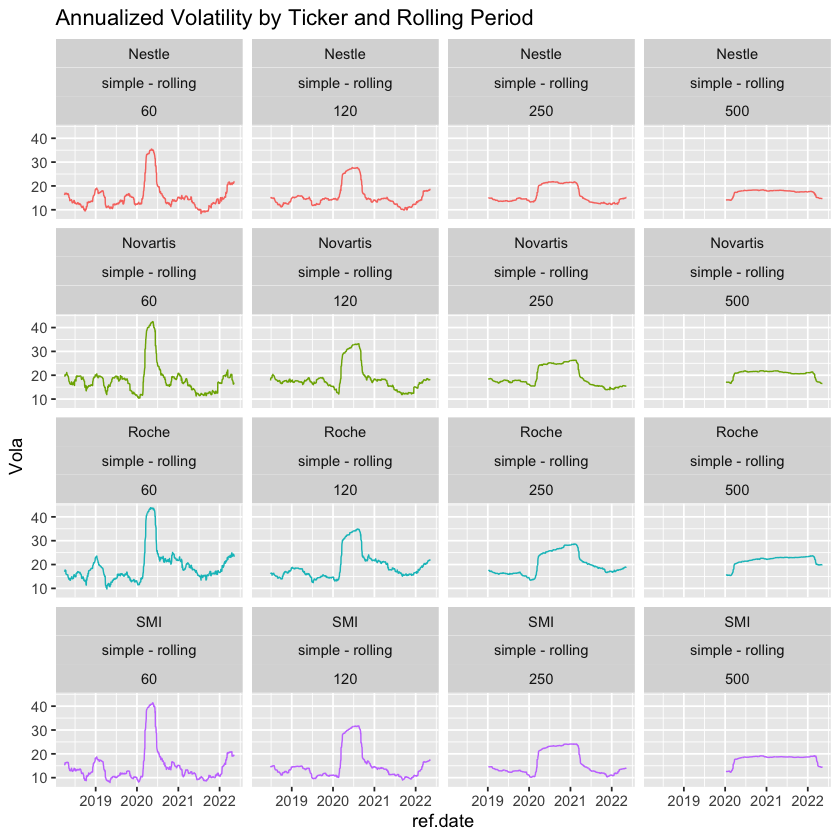

In [184]:
# PLOT VOLA per Ticker, Rolling Period
ggplot(rolling.vola.correl.result.table[rolling.vola.correl.result.table$type=="vola",], aes(y=estimator*sqrt(250)*100, x=ref.date, colour=friendly.name)) + 
  geom_line(size=0.4 ) + ylab("Vola") + ggtitle("Annualized Volatility by Ticker and Rolling Period") + 
  scale_x_date(date_breaks = "1 year", date_labels = "%Y") + 
  theme(legend.position="none") +
  facet_wrap(vars(friendly.name,method,n.days.rolling))   

### Plot: Annualized Volatility by Rolling Period

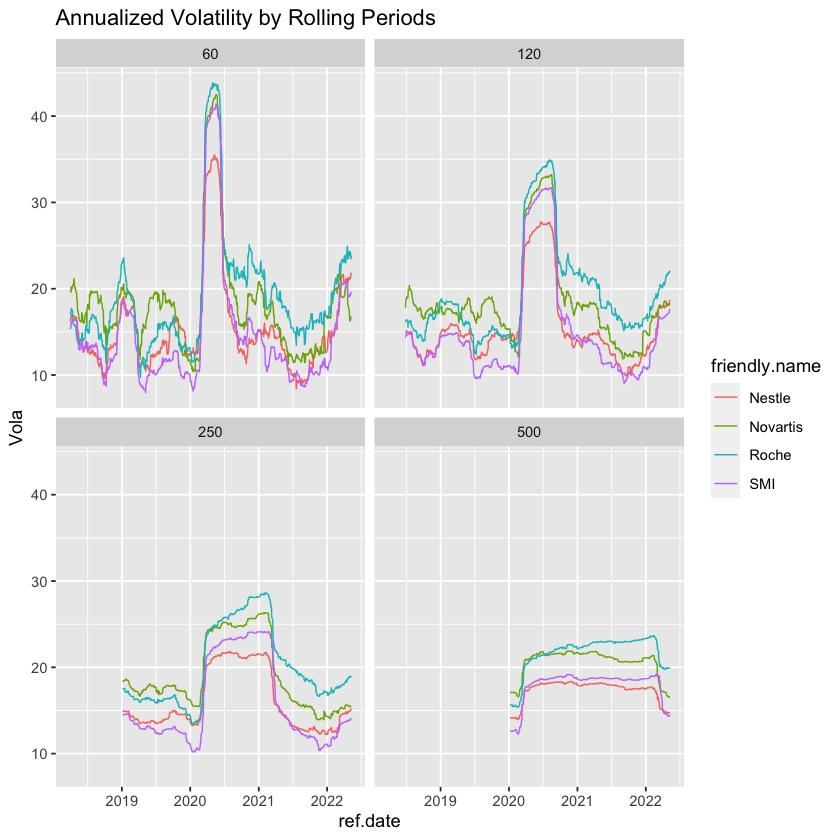

In [185]:
# PLOT VOLA per Rolling Period
ggplot(rolling.vola.correl.result.table[rolling.vola.correl.result.table$type=="vola",], aes(y=estimator*sqrt(250)*100, x=ref.date, colour=friendly.name)) + 
  geom_line(size=0.4 ) + ylab("Vola") + ggtitle("Annualized Volatility by Rolling Periods") + 
  scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
  facet_wrap(vars(n.days.rolling))  

## Correlation

### Plot: Correlation by Tickers and Rolling Period

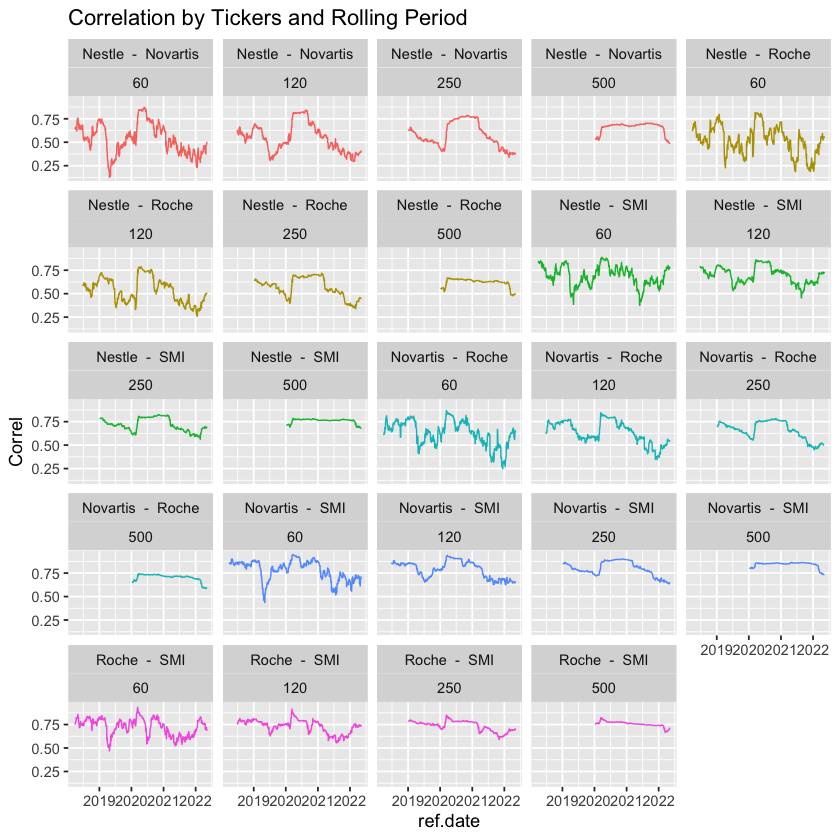

In [186]:
# PLOT CORREL per Ticker, Rolling Period
ggplot(rolling.vola.correl.result.table[rolling.vola.correl.result.table$type=="correl",], aes(y=estimator, x=ref.date, colour=friendly.name)) + 
  geom_line(size=0.4 ) + ylab("Correl") + ggtitle("Correlation by Tickers and Rolling Period") + 
  theme(legend.position="none") +
  facet_wrap(vars(friendly.name,n.days.rolling))   


### Plot: Correlation by Rolling Period

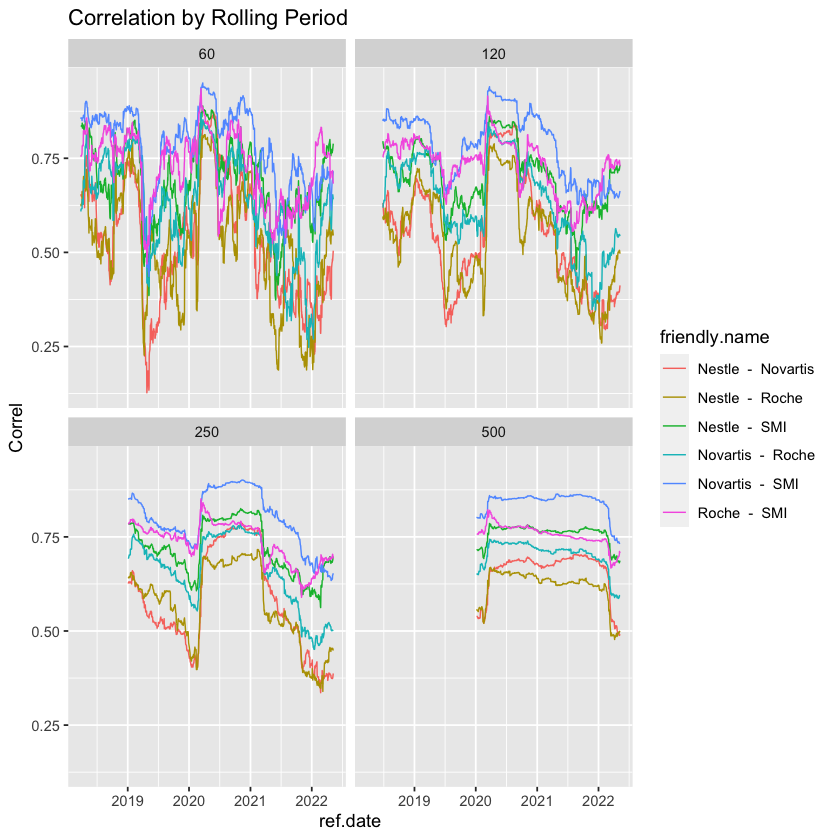

In [187]:
# PLOT CORREL per Ticker, Rolling Period
ggplot(rolling.vola.correl.result.table[rolling.vola.correl.result.table$type=="correl",], aes(y=estimator, x=ref.date, colour=friendly.name)) + 
  geom_line(size=0.4 ) + ylab("Correl") + ggtitle("Correlation by Rolling Period") + 
  facet_wrap(vars(n.days.rolling))   